<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E4-PretrainedModelsPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer Learnning to Flower Recognition using PyTorch 🔥
This dataset contains labeled 4242 images of flowers.


### Content
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Data
You can download data from: [Flowers Recognition Dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

In [1]:
import numpy as np
import pandas as pd
import os
path="./"
os.listdir(path)

['.config', 'archive.zip', 'sample_data']

In [2]:
!unzip archive.zip

Archive:  archive.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: fl

In [3]:
path="./flowers"
os.listdir(path)

['dandelion', 'tulip', 'rose', 'daisy', 'sunflower']

In [4]:
classes=['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [5]:
label_of_file=[]
img_list=[]

for kind in classes:
    kind_parh=os.path.join(path,kind)

    for img in os.listdir(kind_parh):
        img_list.append(os.path.join(kind_parh,img))
        label_of_file.append(kind)

df=pd.DataFrame({'img':img_list,'label':label_of_file})
df.head(3)
df = df.sample(frac=1).reset_index(drop=True)
df.head(2)

,img,label
0,./flowers/tulip/13555215723_cf2c11626b_b.jpg,tulip
1,./flowers/daisy/8759177308_951790e00d_m.jpg,daisy


In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['encode_label'] = encoder.fit_transform(df['label'])

In [7]:
df.head(10)

,img,label,encode_label
0,./flowers/tulip/13555215723_cf2c11626b_b.jpg,tulip,4
1,./flowers/daisy/8759177308_951790e00d_m.jpg,daisy,0
2,./flowers/sunflower/18097401209_910a46fae1_n.jpg,sunflower,3
3,./flowers/tulip/9976515506_d496c5e72c.jpg,tulip,4
4,./flowers/tulip/8713407768_f880df361f.jpg,tulip,4
5,./flowers/daisy/5905502226_bb23bd8fa0_n.jpg,daisy,0
6,./flowers/rose/1461381091_aaaa663bbe_n.jpg,rose,2
7,./flowers/dandelion/18889216716_cd67aec890_n.jpg,dandelion,1
8,./flowers/sunflower/27465811_9477c9d044.jpg,sunflower,3
9,./flowers/dandelion/22785985545_95464115b0_m.jpg,dandelion,1


In [8]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [12]:
example_img = cv2.imread(df['img'][2])
example_img.shape

(240, 320, 3)

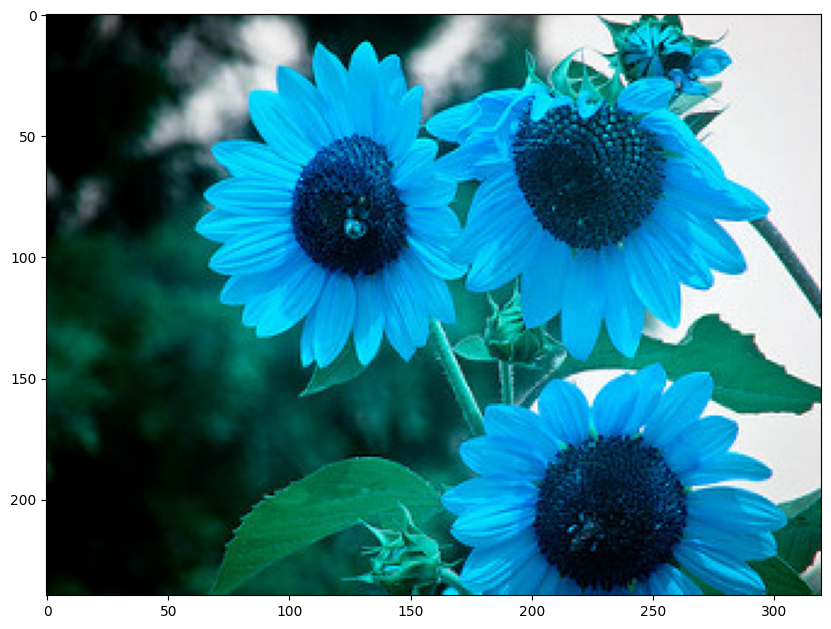

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(example_img)
plt.show()

In [14]:
import numpy as np
x=[]
for img in df['img']:
    try:
        img = cv2.imread(img)
        img = cv2.resize(img, (150, 150))
        img = img / 255.0  # normalize
        x.append(img)      # img

    except:
        print(f"Error loading image: {img}")

## Modeling

In [23]:
# using dataloader
X_train = DataLoader(x, batch_size=32, shuffle=True)
y_train = DataLoader(df['encode_label'], batch_size=32, shuffle=True)

In [18]:
# make model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.5MB/s]


In [19]:
# train Model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [28]:
# train model
def train_model(model, criterion, optimizer, num_epochs=25):
  model.train()
  # Cast the model weights to double precision (float64)
  model = model.double()
  for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in zip(X_train, y_train):
      optimizer.zero_grad()
      # Permute the dimensions of the input tensor
      inputs = inputs.permute(0, 3, 1, 2) # Change the order of dimensions from [batch_size, height, width, channels] to [batch_size, channels, height, width]
      # Cast the inputs to double precision (float64)
      inputs = inputs.double()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * inputs.size(0)
      print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss/len(X_train)}")

In [26]:
# Test Model
def test_model(model):
  model.eval()
  test_loss = 0.0
  correct = 0
  with torch.no_grad():
    for inputs, labels in zip(X_train, y_train):
      # Permute the dimensions of the input tensor
      inputs = inputs.permute(0, 3, 1, 2) # Change the order of dimensions from [batch_size, height, width, channels] to [batch_size, channels, height, width]
      outputs = model(inputs)
      test_loss += criterion(outputs, labels).item() * inputs.size(0)
      pred = outputs.argmax(dim=1, keepdim=True)
      correct += pred.eq(labels.view_as(pred)).sum().item()
  test_loss /= len(X_train.dataset)
  test_accuracy = 100. * correct / len(X_train.dataset)
  print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(X_train.dataset)} ({test_accuracy:.0f}%)')

In [16]:
torch.cuda.is_available()

False

In [ ]:
# training
train_model(model, criterion, optimizer, num_epochs=25)

Epoch 1/25 Loss: 0.44441300248507165
Epoch 1/25 Loss: 0.8885583492633689
Epoch 1/25 Loss: 1.3327417055221642
Epoch 1/25 Loss: 1.777656682541232
Epoch 1/25 Loss: 2.1646577794302986
Epoch 1/25 Loss: 2.5925296649147773
Epoch 1/25 Loss: 3.000092472052628
Epoch 1/25 Loss: 3.3937337397468554
Epoch 1/25 Loss: 3.8473223631562345
Epoch 1/25 Loss: 4.212919812262329
Epoch 1/25 Loss: 4.643550711027633
Epoch 1/25 Loss: 5.096250977851599
Epoch 1/25 Loss: 5.538878546993226
Epoch 1/25 Loss: 5.932071799633143
Epoch 1/25 Loss: 6.3457978145845795
Epoch 1/25 Loss: 6.778615080418556
Epoch 1/25 Loss: 7.165853392586865
Epoch 1/25 Loss: 7.562924090212806
Epoch 1/25 Loss: 7.966693110746101
Epoch 1/25 Loss: 8.365750822779498
Epoch 1/25 Loss: 8.794305223208676
Epoch 1/25 Loss: 9.202753882556925
Epoch 1/25 Loss: 9.630745916689767
Epoch 1/25 Loss: 10.016871581372133
Epoch 1/25 Loss: 10.457277546420928
Epoch 1/25 Loss: 10.88841946975355
Epoch 1/25 Loss: 11.301267926420337
Epoch 1/25 Loss: 11.703755513238931
Epoch 1